# ComSeg usage

[ComSeg](https://github.com/fish-quant/ComSeg)  is a transcript-based segmentation method that creates a KNN graph of RNA molecules, weighted by the co-expression of RNA species. Initially, this KNN graph is partitioned into communities of RNAs likely to belong to the same cell. ComSeg then merges these RNA communities to compute the final cell segmentation. The method uses nucleus segmentation as prior to initialize the partitioning of the KNN graph of RNA molecules.  
ComSeg only segments cells with their nuclei segmented and does not take into account cells without missing nucleus.  

If nucleus segmentation is not available, ComSeg can operate using  other staining segmentation or solely nucleus centroids obtained from other sources. For more details, please refer to the [ComSeg documentation](https://comseg.readthedocs.io/en/latest/).

## Requirements

To use ComSeg, run `pip install comseg` in the same environment as `sopa`. For more installation options, refer to their [installation guide](https://comseg.readthedocs.io/en/latest/installation_guide.html).

Then, choose one the the three use cases (i.e., Snakemake or CLI or API) below.

## Snakemake usage
You can run ComSeg with snakemake in a similar way than the other methods. You can run the toy dataset as follow:

```sh
snakemake --config sdata_path=tuto.zarr --configfile=config/toy/uniform_comseg.yaml --cores 1 --use-conda
```

See [here](https://github.com/gustaveroussy/sopa/tree/master/workflow/config) for MERSCOPE/Xenium/CosMX config files.

## API usage

In this tutorial, we first compute the nucleus segmentation prior using Cellpose on the DAPI staining


In [1]:
import sopa

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### 1. Running Cellpose as a prior

First, we generate the bounding boxes of the patches on which Cellpose will be run. Here, the patches have a width and height of 1500 pixels and an overlap of 50 pixels. We advise bigger sizes for real datasets (see our default parameters in one of our config files). On the toy dataset, this will generate 4 patches.

In [7]:
### Load the data
sdata = sopa.io.toy_dataset(add_nan_gene_name=False)  # here, we use the toy dataset

sopa.make_image_patches(sdata, patch_width=1200, patch_overlap=50)

sopa.segmentation.cellpose(sdata, ["DAPI"], diameter=35)

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell
[INFO] (sopa.patches._patches) 4 patches were added to sdata['image_patches']
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for

### 2. Generating Patches for ComSeg

Once the nuclei are segmented, we generate the bounding boxes of the patches on which ComSeg will be run. ComSeg also requires the nuclei centroids from the Cellpose segmentation. Therefore, we specify the `prior_shapes_key` argument, and choose `write_cells_centroids=True`: 

In [ ]:
sopa.make_transcript_patches(sdata, prior_shapes_key="cellpose_boundaries", write_cells_centroids=True)

[########################################] | 100% Completed | 340.43 ms


[INFO] (sopa.patches._transcripts) 1 patche(s) were added to sdata['transcripts_patches']


### 3. Running ComSeg on each patch

Parameters for ComSeg can be gathered into a single configuration dictionary. Below is a simple configuration example for using ComSeg. For a more comprehensive description of the configuration dictionary, please refer to the [documentation](https://comseg.readthedocs.io/en/latest/userguide/Minimal_example.html#Comprensive-description-of-configuration-dictionnary)

Of note, ComSeg segments cells as a point cloud of RNA. To generate cell shapes from the segmented RNA point clouds, ComSeg leverages alpha shapes. An important parameter to set is ```alpha```, which influences the shape of the generated cell polygons. More about `alpha` shapes can be found [here](https://en.wikipedia.org/wiki/Alpha_shape)

In [10]:
config = {
    "dict_scale": {"x": 1, "y": 1, "z": 1},  # spot coordinates already in µm
    "mean_cell_diameter": 15,
    "max_cell_radius": 25,
    "norm_vector": False,
    "alpha": 0.5,  # alpha value to compute the polygon https://pypi.org/project/alphashape/
    "allow_disconnected_polygon": False,
    "min_rna_per_cell": 5,  # minimal number of RNAs for a cell to be taken into account
    "gene_column": "genes",
}

sopa.segmentation.comseg(sdata, config)



100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

100%|██████████| 5/5 [00:00<00:00, 433.76it/s]

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/comseg/model.py:347: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for node in self.community_anndata.obs["node_index"][comm_index]:
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/comseg/model.py:349: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nn_expression_vector = nn_expression_vector / len(self.community_anndata.obs["node_index"][comm_index])

100%|██████████| 1/1 [00:08<00:00,  8.61s/it]
OMP: Info #276: omp_set_nested r

### 4. Aggregation
As for all other methods, we can run aggregation: transcripts inside each cell are counted and added in a ```AnnData``` object in 
```sdata.tables["table"]```

In [11]:
sopa.aggregate(sdata)

[INFO] (sopa.aggregation.aggregation) Using existing table for aggregation
[WARNING] (sopa.aggregation.aggregation) sdata.table is already existing. Transcripts are not count again.
[INFO] (sopa.aggregation.channels) Aggregating channels intensity over 372 cells with mode='average'


[########################################] | 100% Completed | 103.58 ms


[INFO] (sopa.aggregation.aggregation) Filtering 0 cells
/Users/quentinblampey/dev/sopa/sopa/aggregation/aggregation.py:177: ImplicitModificationWarning: Setting element `.obsm['intensities']` of view, initializing view as actual.
  self.table.obsm[SopaKeys.INTENSITIES_OBSM] = pd.DataFrame(
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `comseg_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:116: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


### 5. Check the segmentation

In [12]:
import spatialdata_plot

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].


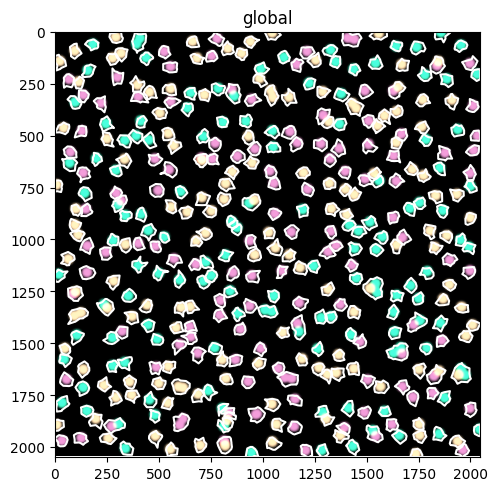

In [15]:
sdata\
    .pl.render_images("image")\
    .pl.render_shapes("comseg_boundaries", outline_alpha=1, fill_alpha=0, outline_color="w")\
    .pl.show("global")

You can also use the Xenium Explorer:

In [16]:
sopa.io.write("tuto.explorer", sdata)

[INFO] (sopa.io.explorer.table) Writing table with 5 columns
[INFO] (sopa.io.explorer.table) Writing 3 cell categories: image_name, region, slide
[INFO] (sopa.io.explorer.shapes) Writing 372 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[

## CLI usage

First, follow the original [CLI tutorial](https://gustaveroussy.github.io/sopa/tutorials/cli_usage/) until you finished the "Cellpose segmentation" section, and then, continue below.

####  1. Save a ComSeg config file as a config.json file

We display below a minimal example of a ComSeg `config.json` file

```json
{
    "dict_scale": {
        "x": 1,
        "y": 1,
        "z": 1
    },
    "mean_cell_diameter": 15,
    "max_cell_radius": 20,
    "allow_disconnected_polygon" : true,
    "alpha": 0.5,
    "min_rna_per_cell": 5,
    "gene_column": "genes",
    "norm_vector": false
}
```


If you did not install the needed external R packages, set ```"norm_vector": false```. More information on the parameters can be found in the [ComSeg documentation](https://comseg.readthedocs.io/en/latest/userguide/Minimal_example.html).

#### 2. Create the ComSeg patches
On the toy dataset, this will generate 4 patches.
```
sopa patchify transcripts tuto.zarr --patch-width-microns 200 --prior-shapes-key cellpose_boundaries --write-cells-centroids
```
The `prior-shapes-key` argument is the name of the nuclei boundaries shape in the sdata object that will be used for the prior and centroid. In this example, it is set to `cellpose_boundaries`, which assumes that the Cellpose segmentation has already been run.

#### 3. Run ComSeg 

```sopa segmentation comseg tuto.zarr --config '"config.json"'```

#### 4. Finish with the standard CLI commands

You can finish as in the original [CLI tutorial](https://gustaveroussy.github.io/sopa/tutorials/cli_usage/).

E.g., you can run:

```sopa aggregate tuto.zarr --aggregate-genes --aggregate-channels --min-transcripts 10```

```sopa annotate fluorescence tuto.zarr --marker-cell-dict '{"CK": "Tumoral cell", "CD3": "T cell", "CD20": "B cell"}'```

```sopa explorer write tuto.zarr```